In [1]:
import _models_utils
import _tiles_utils
import os
import glob
import itertools
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras import callbacks
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("Entrenando en GPU.")
else:
    print("Advertencia: Entrenando en CPU, esto podría ser más lento.")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) disponible(s) y configurada(s) para uso.")
    except RuntimeError as e:
        print(e)
else:
    print("No se encontró GPU.")


Entrenando en GPU.
1 GPU(s) disponible(s) y configurada(s) para uso.


In [3]:
# Cargar datos con augmentación
use_augmentation = False  # Definimos si se usa augmentación

try:
    # Intentamos cargar los datasets de entrenamiento, validación y prueba
    train_data, val_data, test_data = _models_utils.load_data_with_prefetch(use_augmentation=use_augmentation)
    print("Los datos se han cargado exitosamente.")
except Exception as error:
    # Manejamos posibles errores al cargar los datos
    print(f"Error al intentar cargar los datos: {error}")


Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.
Los datos se han cargado exitosamente.


In [4]:
# Obtener el tamaño de los datasets de entrenamiento y validación
train_data_size = train_data.cardinality().numpy()
val_data_size = val_data.cardinality().numpy()

# Imprimimos el tamaño de los datasets en número de lotes (batches)
print(f"Tamaño del dataset de entrenamiento: {train_data_size} lotes")
print(f"Tamaño del dataset de validación: {val_data_size} lotes")


Tamaño del dataset de entrenamiento: 125 lotes
Tamaño del dataset de validación: 25 lotes


In [5]:
# Iteramos sobre el primer lote del dataset de entrenamiento para verificar las dimensiones
for image_batch, label_batch in train_data.take(1):
    # Imprimimos las dimensiones de las imágenes (debe ser: (batch_size, 256, 256, 4))
    print(image_batch.shape)
    # Imprimimos las dimensiones de las etiquetas
    print(label_batch.shape)


(1, 16, 256, 256, 4)
(1, 16, 256, 256, 1)


In [6]:
from _models_utils import reshape_data

# Aplicamos la función para aplanar el dataset de entrenamiento, validación y prueba
train_data = train_data.map(reshape_data)
val_data = val_data.map(reshape_data)
test_data = test_data.map(reshape_data)

In [7]:
# Crear directorios para almacenar resultados, incluyendo gráficos, pesos y predicciones
output_directory = '../results/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + '_UNET_AUG/'

if not os.path.exists(output_directory):
    # Creamos el directorio base si no existe
    os.makedirs(output_directory)
    
    # Creamos subdirectorios para gráficos, pesos del modelo y predicciones
    os.makedirs(os.path.join(output_directory, 'plots'))
    os.makedirs(os.path.join(output_directory, 'weights'))
    os.makedirs(os.path.join(output_directory, 'predictions'))

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, concatenate

def build_unet_model(input_shape):
    """
    Construye un modelo U-Net para segmentación de imágenes.

    Parámetros:
    -----------
    input_shape : tuple
        Forma de entrada de las imágenes (altura, ancho, canales).

    Retorna:
    --------
    tf.keras.Model
        El modelo U-Net compilado.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder (codificador)
    conv_block_1 = Conv2D(32, (3, 3), padding='same')(inputs)  # Filtros 32
    conv_block_1 = BatchNormalization()(conv_block_1)
    conv_block_1 = Activation('relu')(conv_block_1)
    conv_block_1 = Conv2D(32, (3, 3), padding='same')(conv_block_1)
    conv_block_1 = BatchNormalization()(conv_block_1)
    conv_block_1 = Activation('relu')(conv_block_1)
    pooling_1 = MaxPooling2D(pool_size=(2, 2))(conv_block_1)

    conv_block_2 = Conv2D(64, (3, 3), padding='same')(pooling_1)  # Filtros 64
    conv_block_2 = BatchNormalization()(conv_block_2)
    conv_block_2 = Activation('relu')(conv_block_2)
    conv_block_2 = Conv2D(64, (3, 3), padding='same')(conv_block_2)
    conv_block_2 = BatchNormalization()(conv_block_2)
    conv_block_2 = Activation('relu')(conv_block_2)
    pooling_2 = MaxPooling2D(pool_size=(2, 2))(conv_block_2)

    # Bridge (conexión)
    conv_block_3 = Conv2D(128, (3, 3), padding='same')(pooling_2)  # Filtros 128
    conv_block_3 = BatchNormalization()(conv_block_3)
    conv_block_3 = Activation('relu')(conv_block_3)
    conv_block_3 = Conv2D(128, (3, 3), padding='same')(conv_block_3)
    conv_block_3 = BatchNormalization()(conv_block_3)
    conv_block_3 = Activation('relu')(conv_block_3)

    # Decoder (decodificador)
    upsample_1 = concatenate([UpSampling2D(size=(2, 2))(conv_block_3), conv_block_2], axis=-1)
    conv_block_4 = Conv2D(64, (3, 3), padding='same')(upsample_1)  # Filtros 64
    conv_block_4 = BatchNormalization()(conv_block_4)
    conv_block_4 = Activation('relu')(conv_block_4)
    conv_block_4 = Conv2D(64, (3, 3), padding='same')(conv_block_4)
    conv_block_4 = BatchNormalization()(conv_block_4)
    conv_block_4 = Activation('relu')(conv_block_4)

    upsample_2 = concatenate([UpSampling2D(size=(2, 2))(conv_block_4), conv_block_1], axis=-1)
    conv_block_5 = Conv2D(32, (3, 3), padding='same')(upsample_2)  # Filtros 32
    conv_block_5 = BatchNormalization()(conv_block_5)
    conv_block_5 = Activation('relu')(conv_block_5)
    conv_block_5 = Conv2D(32, (3, 3), padding='same')(conv_block_5)
    conv_block_5 = BatchNormalization()(conv_block_5)
    conv_block_5 = Activation('relu')(conv_block_5)

    # Capa de salida
    output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv_block_5)

    # Definimos el modelo U-Net
    return tf.keras.Model(inputs=inputs, outputs=output_layer)


In [9]:
# Definimos la forma de entrada para el modelo U-Net
input_dimensions = (256, 256, 4)

# Creamos el modelo U-Net usando la función build_unet_model
unet_model = build_unet_model(input_dimensions)

# Mostramos el resumen de la estructura del modelo U-Net
unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
# Compilamos el modelo U-Net con el optimizador Adam y la función de pérdida binaria
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Definimos el callback para guardar los pesos del modelo durante el entrenamiento
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(output_directory, 'weights', 'model.{epoch:02d}-{val_loss:.4f}.weights.h5'),
    save_weights_only=True,  # Solo guardamos los pesos del modelo
    save_best_only=True,  # Guardamos solo el mejor modelo (basado en la métrica de validación)
    monitor='val_accuracy',  # Monitorizamos la precisión en el conjunto de validación
    mode='max',  # Buscamos el valor máximo de 'val_accuracy'
    verbose=1  # Mostramos información adicional durante el guardado
)

# Definimos el número de épocas para el entrenamiento
num_epochs = 20

# Entrenamos el modelo usando los datasets de entrenamiento y validación, y aplicamos el callback para guardar pesos
training_history = unet_model.fit(train_data, 
                                  epochs=num_epochs, 
                                  validation_data=val_data, 
                                  callbacks=[checkpoint_callback])


Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9410
Epoch 1: val_accuracy improved from -inf to 0.91096, saving model to ../results/2024-11-11_12-33-23_UNET_AUG/weights\model.01-0.2708.weights.h5
125/125 [==============================] - 40s 274ms/step - loss: 0.1605 - accuracy: 0.9410 - val_loss: 0.2708 - val_accuracy: 0.9110
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9627
Epoch 2: val_accuracy improved from 0.91096 to 0.96753, saving model to ../results/2024-11-11_12-33-23_UNET_AUG/weights\model.02-0.0890.weights.h5
125/125 [==============================] - 31s 251ms/step - loss: 0.1021 - accuracy: 0.9627 - val_loss: 0.0890 - val_accuracy: 0.9675
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9672
Epoch 3: val_accuracy improved from 0.96753 to 0.96939, saving model to ../results/2024-11-11_12-33-23_UNET_AUG/weights\model.03-0.0772.weights.h5
125/12

In [11]:
# Cargar el modelo con los últimos pesos guardados
try:
    # Obtenemos todos los archivos de pesos del directorio correspondiente
    weights_files = glob.glob(os.path.join(output_directory, 'weights', '*.weights.h5'))
    
    if weights_files:
        # Seleccionamos el archivo más reciente basado en la fecha de creación
        most_recent_weights = max(weights_files, key=os.path.getctime)
        print(f"Cargando el modelo con los pesos más recientes desde: {most_recent_weights}")
        
        # Cargamos los pesos en el modelo
        unet_model.load_weights(most_recent_weights)
        print("Pesos cargados exitosamente.")
    else:
        # Si no se encuentran archivos de pesos, se muestra un mensaje
        print("No se encontraron archivos de pesos.")
except Exception as error:
    # Manejamos cualquier error que ocurra durante la carga de los pesos
    print(f"Error al cargar los pesos del modelo: {error}")

Cargando el modelo con los pesos más recientes desde: ../results/2024-11-11_12-33-23_UNET_AUG/weights\model.18-0.0434.weights.h5
Pesos cargados exitosamente.


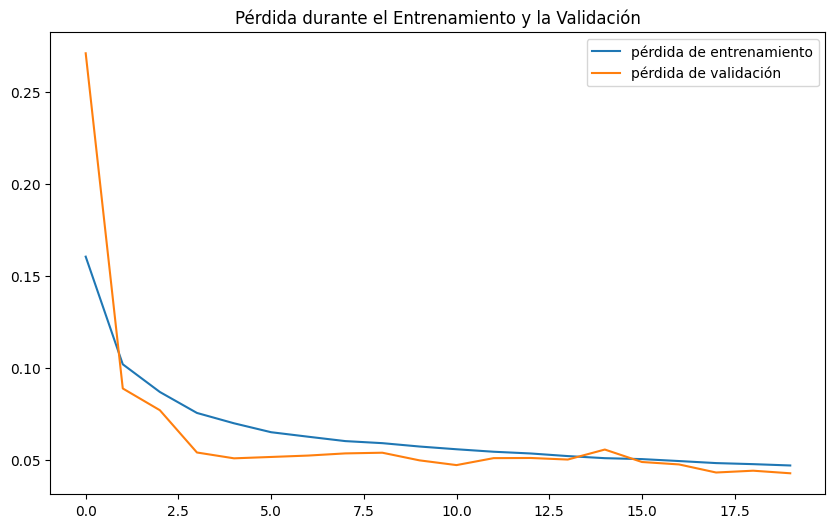

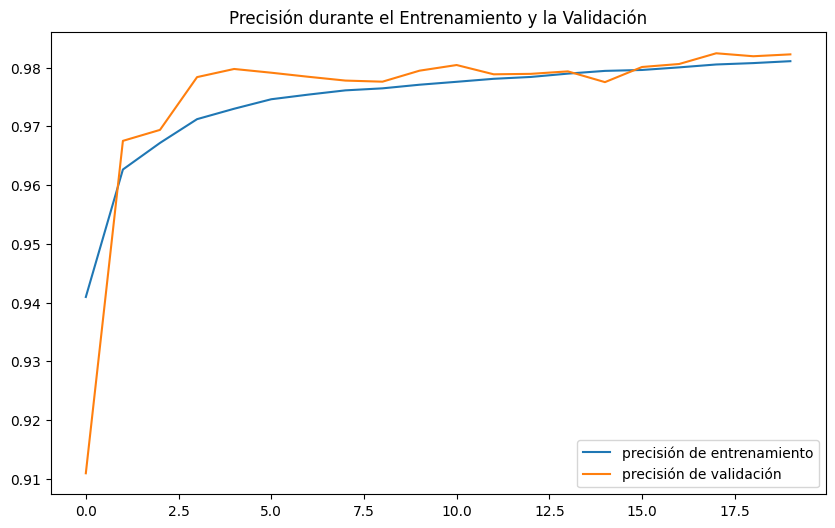

In [12]:

# Graficamos la pérdida (loss) del entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['loss'], label='pérdida de entrenamiento')  # Gráfica de la pérdida en entrenamiento
plt.plot(training_history.history['val_loss'], label='pérdida de validación')  # Gráfica de la pérdida en validación
plt.title('Pérdida durante el Entrenamiento y la Validación')
plt.legend()

# Guardamos la gráfica de pérdida en el directorio correspondiente
plt.savefig(os.path.join(output_directory, 'plots', 'loss.png'))
plt.show()

# Graficamos la precisión (accuracy) del entrenamiento y la validación
plt.figure(figsize=(10, 6))
plt.plot(training_history.history['accuracy'], label='precisión de entrenamiento')  # Gráfica de la precisión en entrenamiento
plt.plot(training_history.history['val_accuracy'], label='precisión de validación')  # Gráfica de la precisión en validación
plt.title('Precisión durante el Entrenamiento y la Validación')
plt.legend()

# Guardamos la gráfica de precisión en el directorio correspondiente
plt.savefig(os.path.join(output_directory, 'plots', 'accuracy.png'))
plt.show()

In [13]:
import _models_utils
# Guardar el modelo en formato .h5
unet_model.save(os.path.join(output_directory, 'final_model.h5'))

# Guardar el modelo en formato .keras (recomendado para TensorFlow 2.x)
unet_model.save(os.path.join(output_directory, 'model.keras'))

# Cargar el modelo desde un archivo .keras
# unet_model_keras = tf.keras.models.load_model(os.path.join(output_directory, 'model.keras'))

# Generamos predicciones y las guardamos
for prediction_index in range(10):  # Ajusta este valor para generar más o menos predicciones
    _models_utils.show_and_save_predictions(prediction_index, test_data, unet_model, output_directory )


1/1 [==============================] - 0s 24ms/step


In [14]:
import pandas as pd
import os

# Definir los parámetros de augmentación dependiendo si se utiliza augmentación o no
if use_augmentation:
    augmentation_params = {
        "flip_left_right": 0,
        "flip_up_down": 0,
        "gaussian_blur": 0.2,
        "random_noise": 0.0,
        "random_brightness": 0.5,
        "random_contrast": 0.5
    }
else:
    augmentation_params = None  # No hay augmentación

# Configuración de los parámetros de entrenamiento
batch_size = 16
shuffle_data = True

# Evaluamos el modelo y obtenemos las métricas
model_metrics = _models_utils.evaluate_model(
    description="U-net sin atención; dataset final",  # Descripción del modelo
    test_data=test_data,  # Dataset de prueba
    model=unet_model,  # Modelo a evaluar
    input_shape=input_dimensions,  # Dimensiones de entrada del modelo
    is_shuffled=shuffle_data,  # Si los datos fueron mezclados
    batch_size=batch_size,  # Tamaño del lote
    epochs_num=num_epochs,  # Número de épocas de entrenamiento
    augment_settings=augmentation_params,  # Parámetros de augmentación
    threshold=0.5  # Umbral de clasificación para las predicciones
)

# Guardamos las métricas en un archivo CSV
metrics_df = pd.DataFrame(model_metrics)
metrics_df.to_csv(os.path.join(output_directory, 'metrics.csv'), index=False)  # Guardamos las métricas en el directorio


1/1 [==============================] - 0s 30ms/step
